# IMA 208 TP5: homography estimation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import exposure

In this practical work, we will study how to estimate an homography between two given images. We will consider both the simple DLT algorithm (part I) and the RANSAC algorithm (part II).

To reduce the time you need for this practical work, we will use a few pre-implemented functions of openCV. Make sure that your library installation is correct before starting to work.

# Part 1: homography estimation from hand-selected keypoints: DLT algorithm

We assume that we have an image of a documents suffering from severe perspective distortion. The objective of this part is to warp this image (denoted in the following as img2) to remove the distortion using a reference image beeing in the desired pose (denoted as img1).

The following cell enables to vizualize the images using openCV.

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x10ec5f980>)

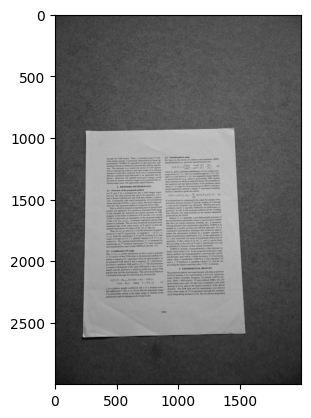

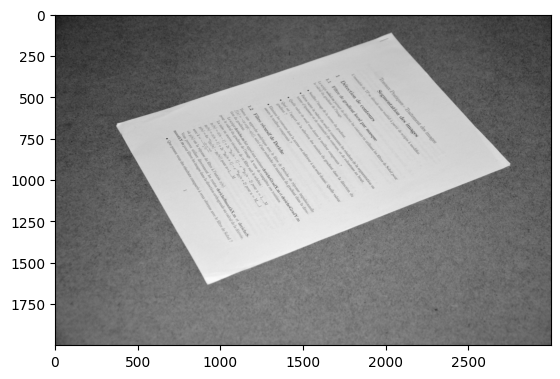

In [2]:
img1 = cv2.cvtColor(cv2.imread('Feuille_redressee.jpg'),cv2.COLOR_BGR2GRAY) # Reference image
img2 = cv2.cvtColor(cv2.imread('Feuille.jpg'),cv2.COLOR_BGR2GRAY) # Image to be processed

plt.figure(),plt.imshow(img1,cmap='gray')
plt.figure(),plt.imshow(img2,cmap='gray')

To correct the homography beetween the to images, we will need some points to match between the two images.

**Question:** how many points do you at least need to estimate the homography? Why?

**Answer:**
4 points. Each point has 2 dof and we need 8 dof to generate the matrix.

**Implementation:** to estimate the homography, some matching keypoints between the reference image and the to-be-porcessed one are given below. They here correspond to the corners of the two documents.

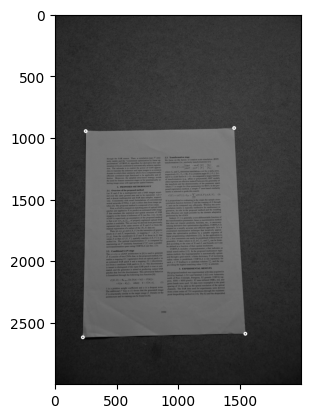

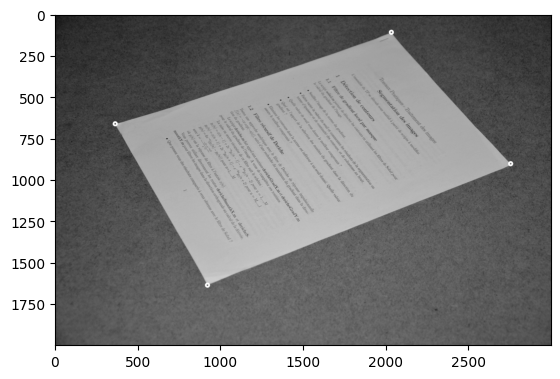

In [3]:
pts1 = [[248,949],[1450,924],[1541,2592],[225,2621]] # Keypoints for img1. Should be a list in format [[first_point_row,first_point_column],[second_point_row,second_point_column],...]
pts2 = [[2030,110],[2750,904],[920,1638],[363,663]] # Keypoints for img2,  keep the same order of the points as pts1.

# Below, we convert the points you found above into cv2 points object for vizualization (no need to change anything)
kp1 = [cv2.KeyPoint(pt[0], pt[1], 1) for pt in pts1]
kp2 = [cv2.KeyPoint(pt[0], pt[1], 1) for pt in pts2]

for i in range(len(pts1)):
    img1c=cv2.circle(img1,pts1[i],radius=10,color=(255,0,0),thickness=10)
plt.figure(),plt.imshow(img1c,cmap='gray')

for i in range(len(pts2)):
    img2c=cv2.circle(img2,pts2[i],radius=10,color=(255,0,0),thickness=10)
plt.figure(),plt.imshow(img2c,cmap='gray')

pts1 = np.array(pts1).T # In all the following, we will use the convention that np.shape(pts1) = [2,number_of_points]
pts2 = np.array(pts2).T # In all the following, we will use the convention that np.shape(pts2) = [2,number_of_points]

**Visualize** the keypoints you found above to check that they are properly assigned.

Now, we will start implementing the DLT.

**Question:** recall what the DLT is. Give a pseudo code. What are its potential flaws and strengths?

**Answer:**
It is the Direct Linear Transform algorithm. We define a matrix $A$ that is $2I \times 9$ based on the keypoints of both images. Then, we solve the following optimization problem:
$$
\arg \min_{h \in \mathbb{R}^9} \| A h \|_2^2
$$
such that $\| h \|_2^2 = 1$.
If we do SVD and write $A = U D V^\top$, then the solution to this optimization problem is precisely the last column of $V^\top$.
Once $h$ is found, one can reconstruct $H$ from $h$ by interpreting each 3 coordinates of $h$ as a row of $H$.

The first step of the DLT algorithm is to normalize the image point.

**Question:** Recall why the normalization is important. Recall how to do it.

**Answer:**
We normalize the points to avoid significant order of magnitude differences in $H$ and decrease the condititoning factor of $A$. We normalize the points by translating their centroid to the origin (subtract the mean) and dividing by a scailing factor s.t. the average distance between points is $\sqrt{2}$.

In the following, we will perform the normalization using the so called *homogeneous* coordinates of the keypoints. The main idea is to add a last coordinate equal to one for each point. The point (x,y) thus becomes (x,y,1) in homogeneous coordinate.

The advantage is that we will be able to do the normalization using a simple matrix product : X_norm = T@X.

**Fill** the blanks in the below implementation.

In [4]:
def normalize_image_points(imageEucl, verbose=True):
    """
    Input: 2D list with x,y image points
    Output: normalized data points
    """

    if verbose:
        print("Normalizing data using similarity matrix...")

    mean, std = imageEucl.mean(axis=1), imageEucl.std(axis=1) # To be filled, (elementwise) mean and std of the data points

    N = imageEucl.shape[1]
    image = np.vstack((imageEucl, np.ones(N))) # Image in homogeneous coordinate
    
    # Define a similarity matrix enabling to normalize the data. Write the cooefficients in Tranformation such that image_norm = image@Transformation
    s = np.sqrt(2) / std
    t_x = mean[0]
    t_y = mean[1]
    
    Transformation = np.array([[1 / s[0], 0, t_x],
                               [0, 1 / s[1], t_y],
                               [0, 0, 1]])
    Transformation = np.linalg.inv(Transformation)

    # Apply transformation on data points
    image_norm = Transformation @ image
    
    # Retrieve normalized image in the original input shape (25, 2)
    image_norm = image_norm[0:2,:]

    return image_norm, Transformation

**Question:** Verify that your data looks properly normalized.

In [5]:
normalize_image_points(np.array(pts1))

Normalizing data using similarity matrix...


(array([[-1.38645288,  1.31017554,  1.5143296 , -1.43805226],
        [-1.39285967, -1.43519583,  1.38947278,  1.43858272]]),
 array([[ 2.24345127e-03,  0.00000000e+00, -1.94282880e+00],
        [ 0.00000000e+00,  1.69344641e-03, -2.99994031e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]))

The second step is to compute the A matrix from the normalized data points.

**Fill** the blanks in the function below.

**Question:** justify the shape of the A matrix.

**Answer:**
Matrix $A$ is $2I \times 9$. Having 9 columns is essential because $h$ represents matrix $H$, which has 9 entries. Having $2I$ rows is due to the fact that each point yields two equations that have to be satisfied by the homography.

In [6]:
def compute_matrix_A(points1, points2, no_points, verbose=True):
    """
    Input: Already normalized correspondences for image1 and image2
    Output: Matrix A as defined in Zisserman p. 91
    """

    A = []

    for i in range(0, no_points):
        x, y = points1[0, i], points1[1, i] # Denote the coordinate in image 1 x and y for shortcut
        x_prime, y_prime = points2[0, i], points2[1, i] # Denote the coordinate in image 2 x_prime and y_prime for shortcut

        # Create A_i according to the fomula given in class
        # here we are assuming w_i and w_i_prime are one
        A.append([0, 0, 0, -x, -y, -1, y_prime * x, y_prime * y, y_prime])
        A.append([x, y, 1, 0, 0, 0, - x_prime * x, - x_prime * y, - x_prime])

    if verbose:
        print()
        print("Stacked matrix A shape:", np.shape(A))

    return np.asarray(A)



We are now ready to code the whole homography computation function. 

**Fill** the gaps below.

In [7]:
def compute_homography(pts1, pts2, verbose=True):

    # Set data points to numpy arrays
    no_points = pts1.shape[1] # Number of points

    # Normalize the data
    image1_normalized, T = normalize_image_points(pts1, verbose)
    image2_normalized, T_prime = normalize_image_points(pts2, verbose)
    
    # Get matrix A
    # A = ...
    A = compute_matrix_A(image1_normalized, image2_normalized, no_points, verbose)

    # Compute SVD of A
    U, S, V = np.linalg.svd(A)
    V = V.T # So that A = USV.T
    
    # Get last column of V (this is the vector h)
    h = V[:, -1]
    
    # Obtain homography by reshaping h (H tilde)
    if verbose:
        print()
        print("Reshaping to get homography H_tilde...")
    H_tilde = h.reshape(3, 3)

    # Denormalize to obtain homography (H) using the transformations and generalized pseudo-inverse
    H = np.linalg.inv(T_prime) @ H_tilde @ T

    if verbose:
        print()
        print("Denormalized to obtain homography H for 2D data points...")
        print("Matrix H:")
        print(H)
    
    return H

**Question:** Apply the compute_homography function to warp the document image 2 into the perspective of document 1. Any comment ?

Normalizing data using similarity matrix...
Normalizing data using similarity matrix...

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[ 1.89710151e-01 -6.17873517e-01  1.79973010e+03]
 [ 3.58788747e-01  2.07651631e-01 -2.17742589e+02]
 [-6.16844041e-05 -4.82980480e-06  6.40775923e-01]]


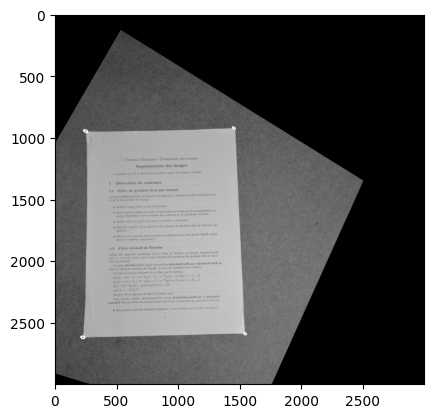

In [8]:
H = compute_homography(pts1,pts2)
homography_matrix_normalized = H
result = cv2.warpPerspective(img2, np.linalg.inv(homography_matrix_normalized),(3000,3000))
plt.imshow(result,cmap='gray')

**Answer:** We see that we are able to successfully warp image 2 into the perspective of image 1. However, there is a big black border on the resulting image. Of course, we cannot "increase" the information from image 2, so it is expected that this would happen.

**Question:** test the sensitivity of the above algorithm to errors in the matching keypoints. Are you able to obtain good results if you have a false match?

Answer to the same question is you have more matching points than the corners.

**Answer:** If we have a mismatch between keypoints, the result is completely false. We see a perspective that does not correspond at all to the one of image 1.

Normalizing data using similarity matrix...
Normalizing data using similarity matrix...

Stacked matrix A shape: (10, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[ 5.24041689e-01 -6.00297995e-02  1.49140349e+02]
 [ 4.50546968e-01  3.63518353e-01 -3.84936127e+02]
 [ 6.13470596e-05  2.98407532e-04 -4.78917277e-02]]


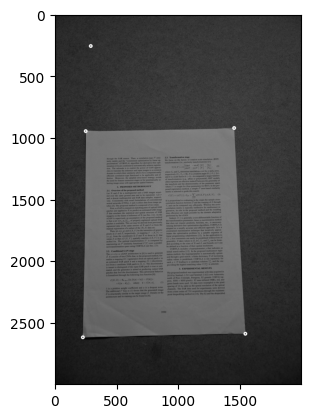

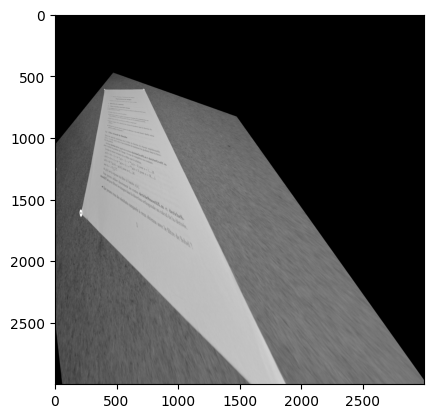

In [9]:
pts1 = [[248,949],[1450,924],[1541,2592],[225,2621]]
pts2 = [[2030,110],[2750,904],[920,1638],[363,663]]

# pts1 = [[248,949],[1450,924],[1541,2592],[225,2621]]
# pts2 = [[2030,110], [2750,904],[363,663], [920,1638]]

pts1.append((300 * np.random.rand(2)).astype(int).tolist())
pts2.append((300 * np.random.rand(2)).astype(int).tolist())

for i in range(len(pts1)):
    img1c_dec=cv2.circle(img1,pts1[i],radius=10,color=(255,0,0),thickness=10)
plt.figure(),plt.imshow(img1c_dec,cmap='gray')

for i in range(len(pts2)):
    img2c_dec=cv2.circle(img2,pts2[i],radius=10,color=(255,0,0),thickness=10)
plt.figure(),plt.imshow(img2c_dec,cmap='gray')

pts1 = np.array(pts1).T # In all the following, we will use the convention that np.shape(pts1) = [2xnumber_of_points]
pts2 = np.array(pts2).T # In all the following, we will use the convention that np.shape(pts1) = [2xnumber_of_points

H = compute_homography(pts1,pts2)
homography_matrix_normalized = H / H[2, 2]
result = cv2.warpPerspective(img2, np.linalg.inv(homography_matrix_normalized),(3000,3000))
plt.imshow(result,cmap='gray')

# Part 2: automatic homography estimation and panorama stitching

To bypass the flaws that we observed with the previous method, we now propose to use a robust homography estimation method, the RANSAC algorithm. As an application, we will consider panorama stitching: from two given overlapping images, create a single one which is a panorama. To do that, we will need to estimate the best homography to warp an image into the perspective of the other. In addition, to avoid the cumbersome choice of the matching points between the two images, we will do an automatic keypoint identification by using the SIFT features.

Let us first load the two considered images.

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x10ee3e720>)

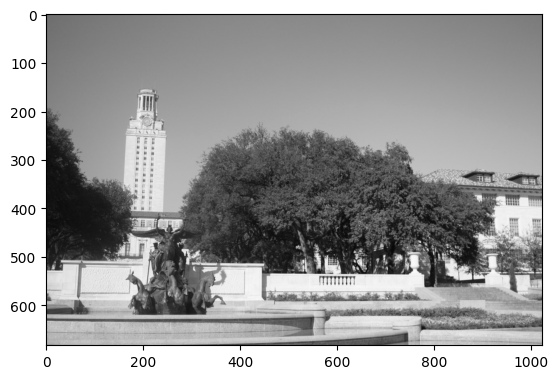

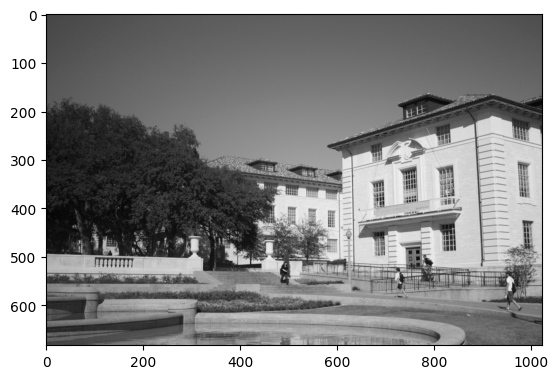

In [10]:
img1c = cv2.cvtColor(cv2.imread('uttower_left.jpg'),cv2.COLOR_BGR2GRAY)
img2c = cv2.cvtColor(cv2.imread('uttower_right.jpg'),cv2.COLOR_BGR2GRAY)

img1 = img1c
img2 = img2c

plt.figure(),plt.imshow(img1,cmap='gray')
plt.figure(),plt.imshow(img2,cmap='gray')

To stitch the two images, we need to have access to pair of corresponding points between image 1 and image 2. To do that, we first need to extract some keypoints in both images (that will be matched later on). We will use here the SIFT descriptors.

**Implement** the SIFT descriptors for both image 1 and image 2. You might be willing to use the cv2.SIFT_create and sift.detectAndCompute.

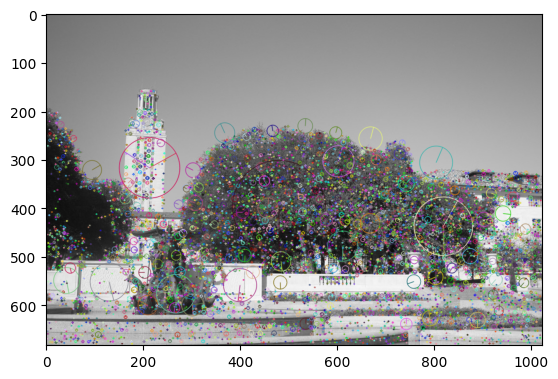

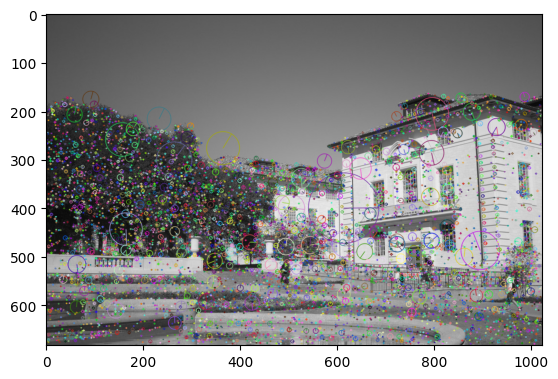

In [11]:
sift = cv2.SIFT_create(contrastThreshold=0.01) # Creates an object of the SIFT class. The larger the threshold, the smaller the number of points
kp1,desc1 = sift.detectAndCompute(img1, None) #kp1 = location of the keypoints, desc1 = corresponding descriptors.

# For visualization
img1c=cv2.drawKeypoints(img1,kp1,img1c,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img1c)
plt.show()

kp2,desc2 = sift.detectAndCompute(img2, None) #kp2 = location of the keypoints, desc2 = corresponding descriptors.
img2c=cv2.drawKeypoints(img2,kp2,img2c,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img2c)

In [12]:
print(len(kp1), desc1.shape)
print(len(kp2), desc2.shape)

7396 (7396, 128)
7552 (7552, 128)


**Question:** explain the shapes of desc1, kp1 and desc2, kp2 and their respective roles.

**Answer:**
`kp1` contains a list of points $(x, y)$. Each point $i$ has a descriptor associated with it, `desc1[i]`. This descriptor is a vector in $\mathbb{R}^128$ that contains various information. We can use this descriptor to match keypoints from image 1 to image 2.
Points that represent the same "thing" in both images should have really close descriptors, and thus we obtain the matches $\mathbf{x}_i \longleftrightarrow \mathbf{x^\prime}_i$.

Now that we have obtained the SIFT descriptor, we have to match them.

**Complete** the following code.

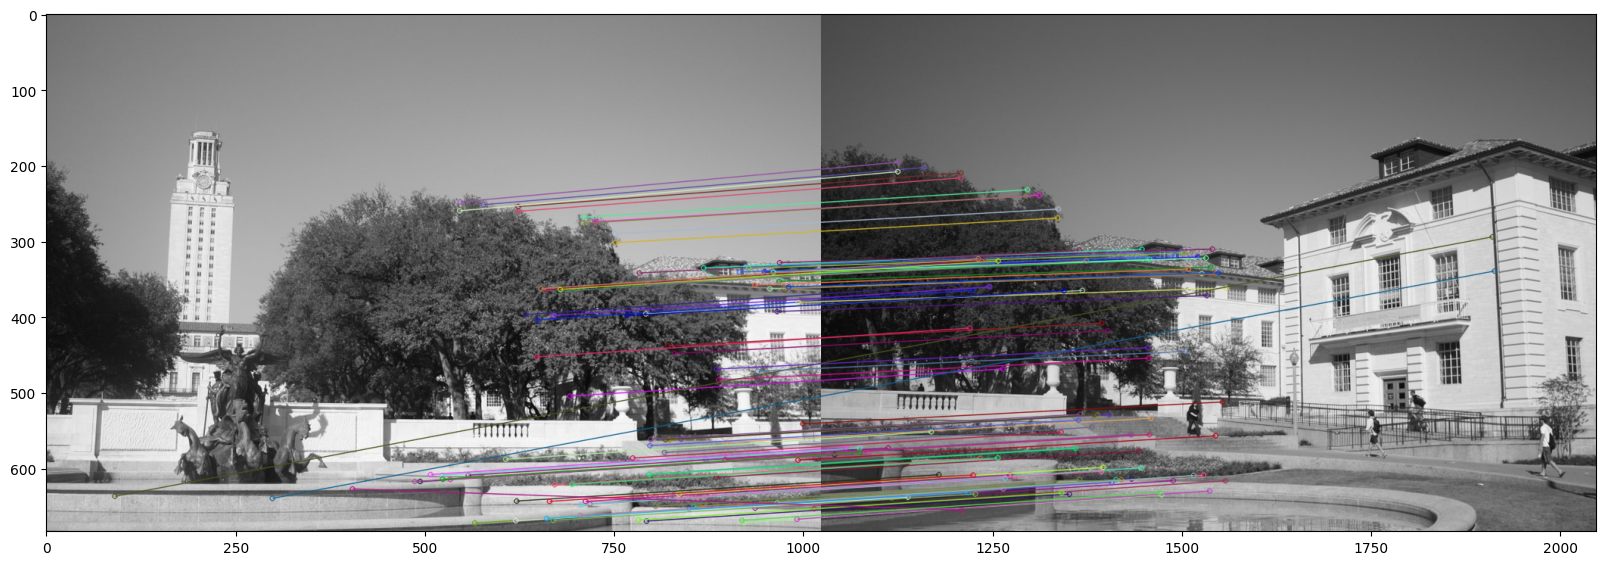

(<Figure size 2000x1200 with 1 Axes>,
 None)

In [13]:
#feature matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(desc1, desc2)
matches = sorted(matches, key=lambda x: x.distance)

# For visualizing the matches
img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:100], img2, flags=2)
plt.figure(figsize=(20,12)),plt.imshow(img3),plt.show()

**Question:** comment the match quality. Do you think that the previous matching would enable a decent homography computation using the DLT algorithm of the first part?

**Answer:**
We see that the keypoints are matched correctly and no obvious outlier is seen. Of course, there is noise present in the detection and matching, but they are overall pretty good.

The following code enables to keep only the coordinates of the 100 best matches in the two images. We will use them as an input of a RANSAC, which will enable to do a robust homography estimation between the two images.

In [14]:
D1 = np.ones((2,100)) # Coordinates in image 1 of the first best matching points
D2 = np.ones((2,100)) # Coordinates in image 2 of the first best matching points
for ii in range(100):
    D1[:,ii] = kp1[matches[ii].queryIdx].pt
    D2[:,ii] = kp2[matches[ii].trainIdx].pt

D1 = D1.astype(int)
D2 = D2.astype(int)

In [15]:
print(D1.shape)

(2, 100)


Now, we are ready to code the RANSAC algorithm.

**Fill** the gaps in the code below.

In [16]:
def ransac(D1, D2, num, threshold, iterations):
    # D1, D2 : matched points between the two images
    # num : number of points to compute the homography
    # threshold : distance threshold for determining if a pair of point in an inlier or an outlier
    # iterations : number of iterations / number of sampling
    
    D1h = np.vstack((D1, np.ones(D1.shape[1]))) # D1h correspond to D1 transformed into homogeneous coordinates
    D2h = np.vstack((D2, np.ones(D2.shape[1]))) # D2h correspond to D2 transformed into homogeneous coordinates
        
    n = D1.shape[1] # Number of points in D1
    

    best_n_inlier = 0
    best_H = np.zeros((3, 3)) # Best homography matrix. Fill the gap with a matrix of the right size full of 0.
    
    for i in range(iterations):
        s = np.random.choice(n, num, replace=False) # Draw randomly 4 indices to extract 4 points among D1 and D2. You can use np.random.choice()
        
        pts1 =  D1[:, s] #pts1 is the chosen points among D1
        pts2 =  D2[:, s] #pts2 is the chosen points among D2
        
        H = compute_homography(pts1, pts2, False) # Compute the corresponding homography. You can reuse the function of part I.
        
        D2_new = np.dot(H, D1h) # Transform the points of D1h to be able to compare them to the ones of D2h
        
        # Normalize D2_new
        D2_new[0, :] = np.divide(D2_new[0, :],D2_new[2, :])
        D2_new[1, :] = np.divide(D2_new[1, :],D2_new[2, :])
        D2_new[2, :] = np.divide(D2_new[2, :],D2_new[2, :])
        
        
        
        SD = np.linalg.norm(D2_new - D2h, ord=2, axis=0) # Compute the distance between D2_new and D2h
        
        inliers = SD < threshold # Compute the inliers
        num_inlier = np.sum(inliers) # Compute the number of inliers
        
        if num_inlier > best_n_inlier: # If you obtained the best result, store the corresponding homography
            best_H = H
            best_n_inlier = num_inlier
            point1 = D1[:2, inliers]
            point2 = D2[:2, inliers]
            in_res = SD[inliers]
    
    
    return best_H, best_n_inlier, point1, point2, in_res

Using the function you implemented above, **launch the RANSAC algorithm** to estimate the homography between the two images.

In [17]:
threshold = 1;
num = 4;
iterations = 1000;
[H, inliers, point1, point2, residue] = ransac(D1, D2, num,threshold, iterations)


Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[ 3.97208735e-01  2.01534310e-01 -2.88223748e+02]
 [ 2.71476481e-02  6.82122275e-01 -1.85916625e+02]
 [ 3.62661015e-05  6.42925252e-04  2.69807204e-02]]
Normalizing data using similarity matrix...
Normalizing data using similarity matrix...

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[ 2.62836435e-01 -3.02640497e+00  1.39529120e+03]
 [ 2.68364470e-01 -2.93607322e+00  1.34485423e+03]
 [ 5.37524729e-04 -5.94603118e-03  2.72812889e+00]]
Normalizing data using similarity matrix...
Normalizing data using similarity matrix...

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[ 4.98495514e-01  7.27418122e-02 -2.76910776e+02]
 [ 8.10468203e-02  5.59284418e-01 -1.31145672e+02]
 [ 1.42245934e-04  2.48

In [18]:
print(H)

[[ 6.08249722e-01 -3.77334770e-02 -2.67588679e+02]
 [ 7.93650816e-02  5.69570545e-01 -7.79093563e+01]
 [ 1.32561915e-04  5.32364656e-06  4.69351434e-01]]


Lastly, **fill the code** below to warp img2 into the same space as img1

In [19]:
result = cv2.warpPerspective(img2, np.linalg.inv(H / H[2, 2]), (img1.shape[1] + img2.shape[1], img1.shape[0]))
result[0:img1.shape[0], 0:img1.shape[1]] = img1

**Question:** Plot the panorama image. How good is it? Any comment?

**Answer**:
The keypoints were able to perfectly match the two iamges and to warp them to create a panorama. However, it is clear where the junction occured due to the difference in light.

(<Figure size 4000x2000 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x10f571e50>)

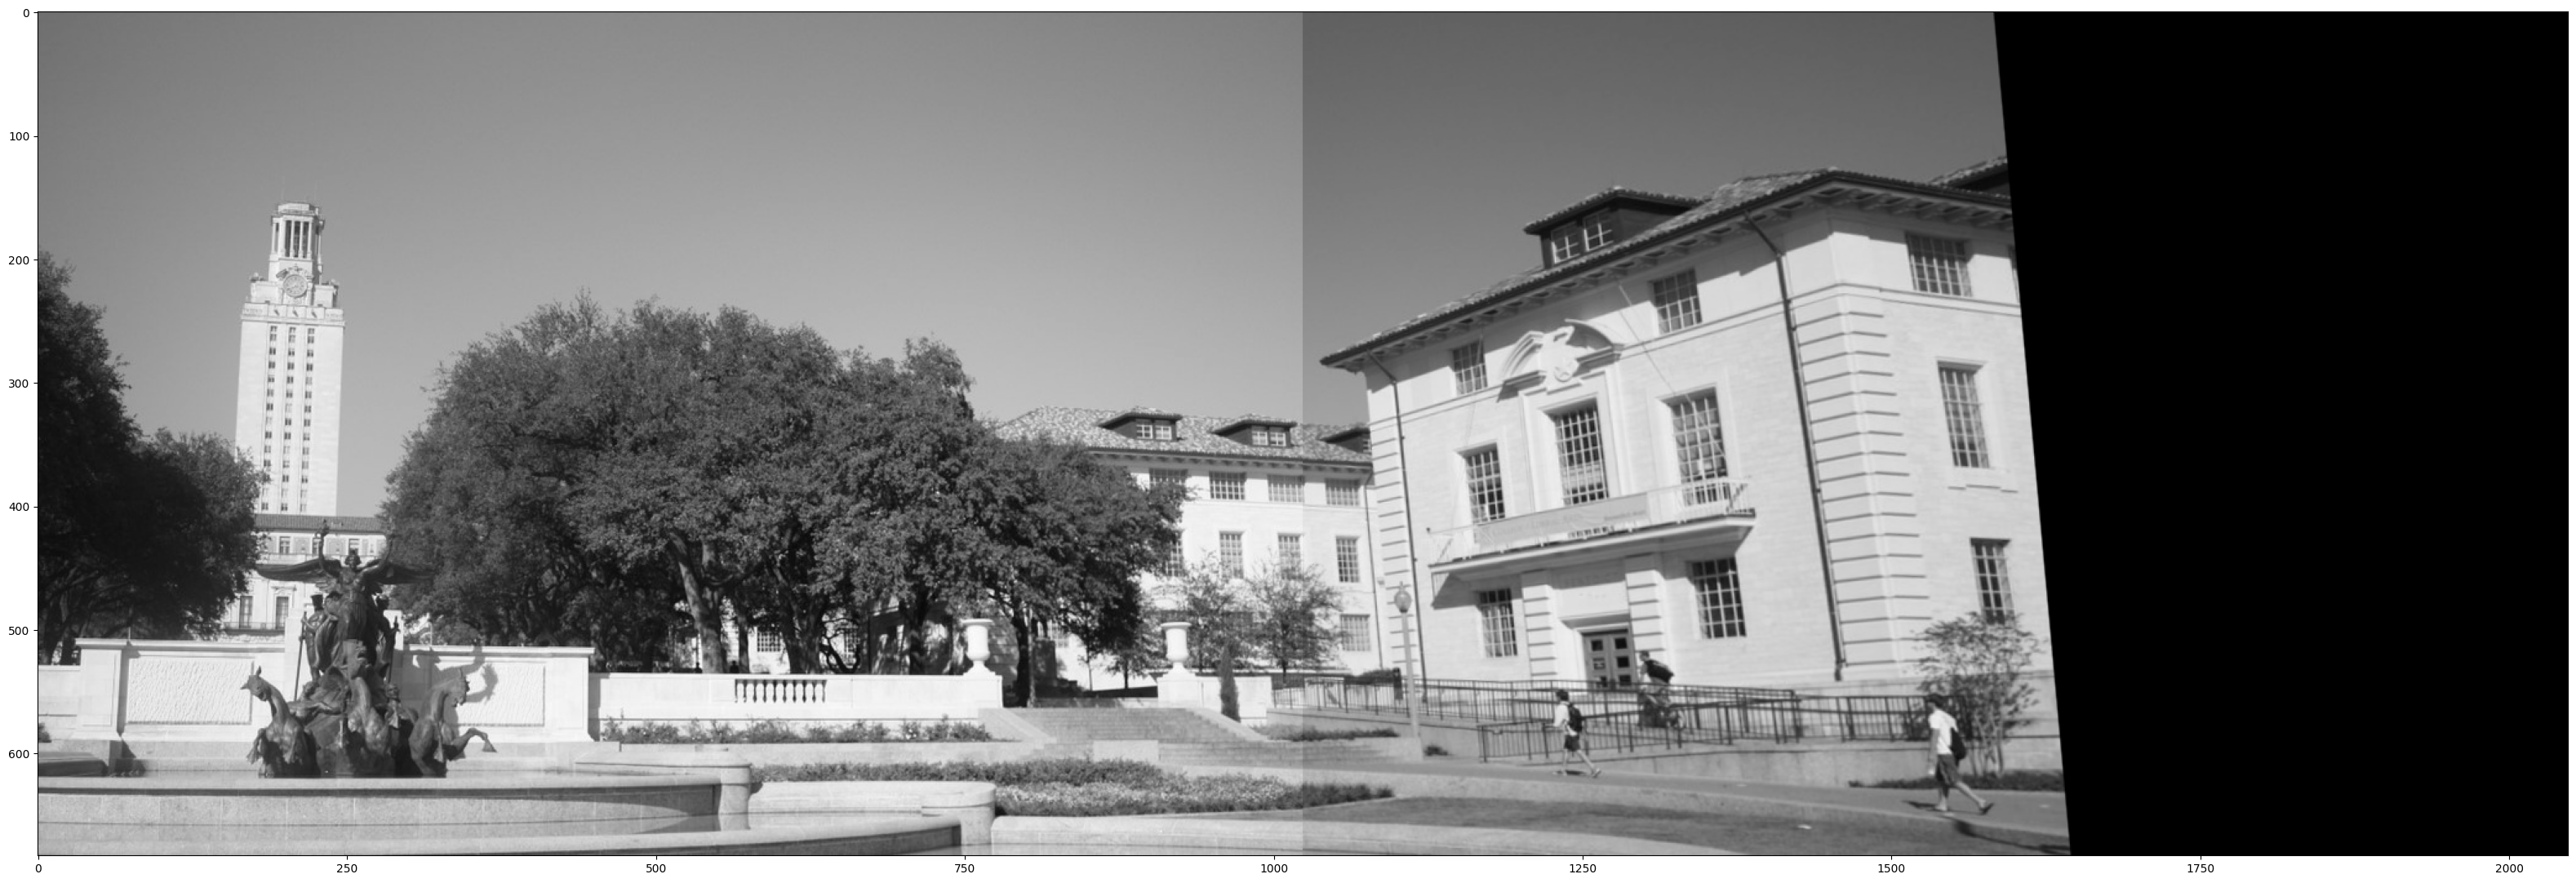

In [20]:
plt.figure(figsize=(40,20)),plt.imshow(result,cmap='gray')

**Bonus**: try other descriptors than the SIFT ones. Try to implement your own.

**Bonus:** try to correct the change of luminosity between the two images so that the panorama look more realistic.

**Answer**: We can match the histograms of the two images to mitigate the problem.

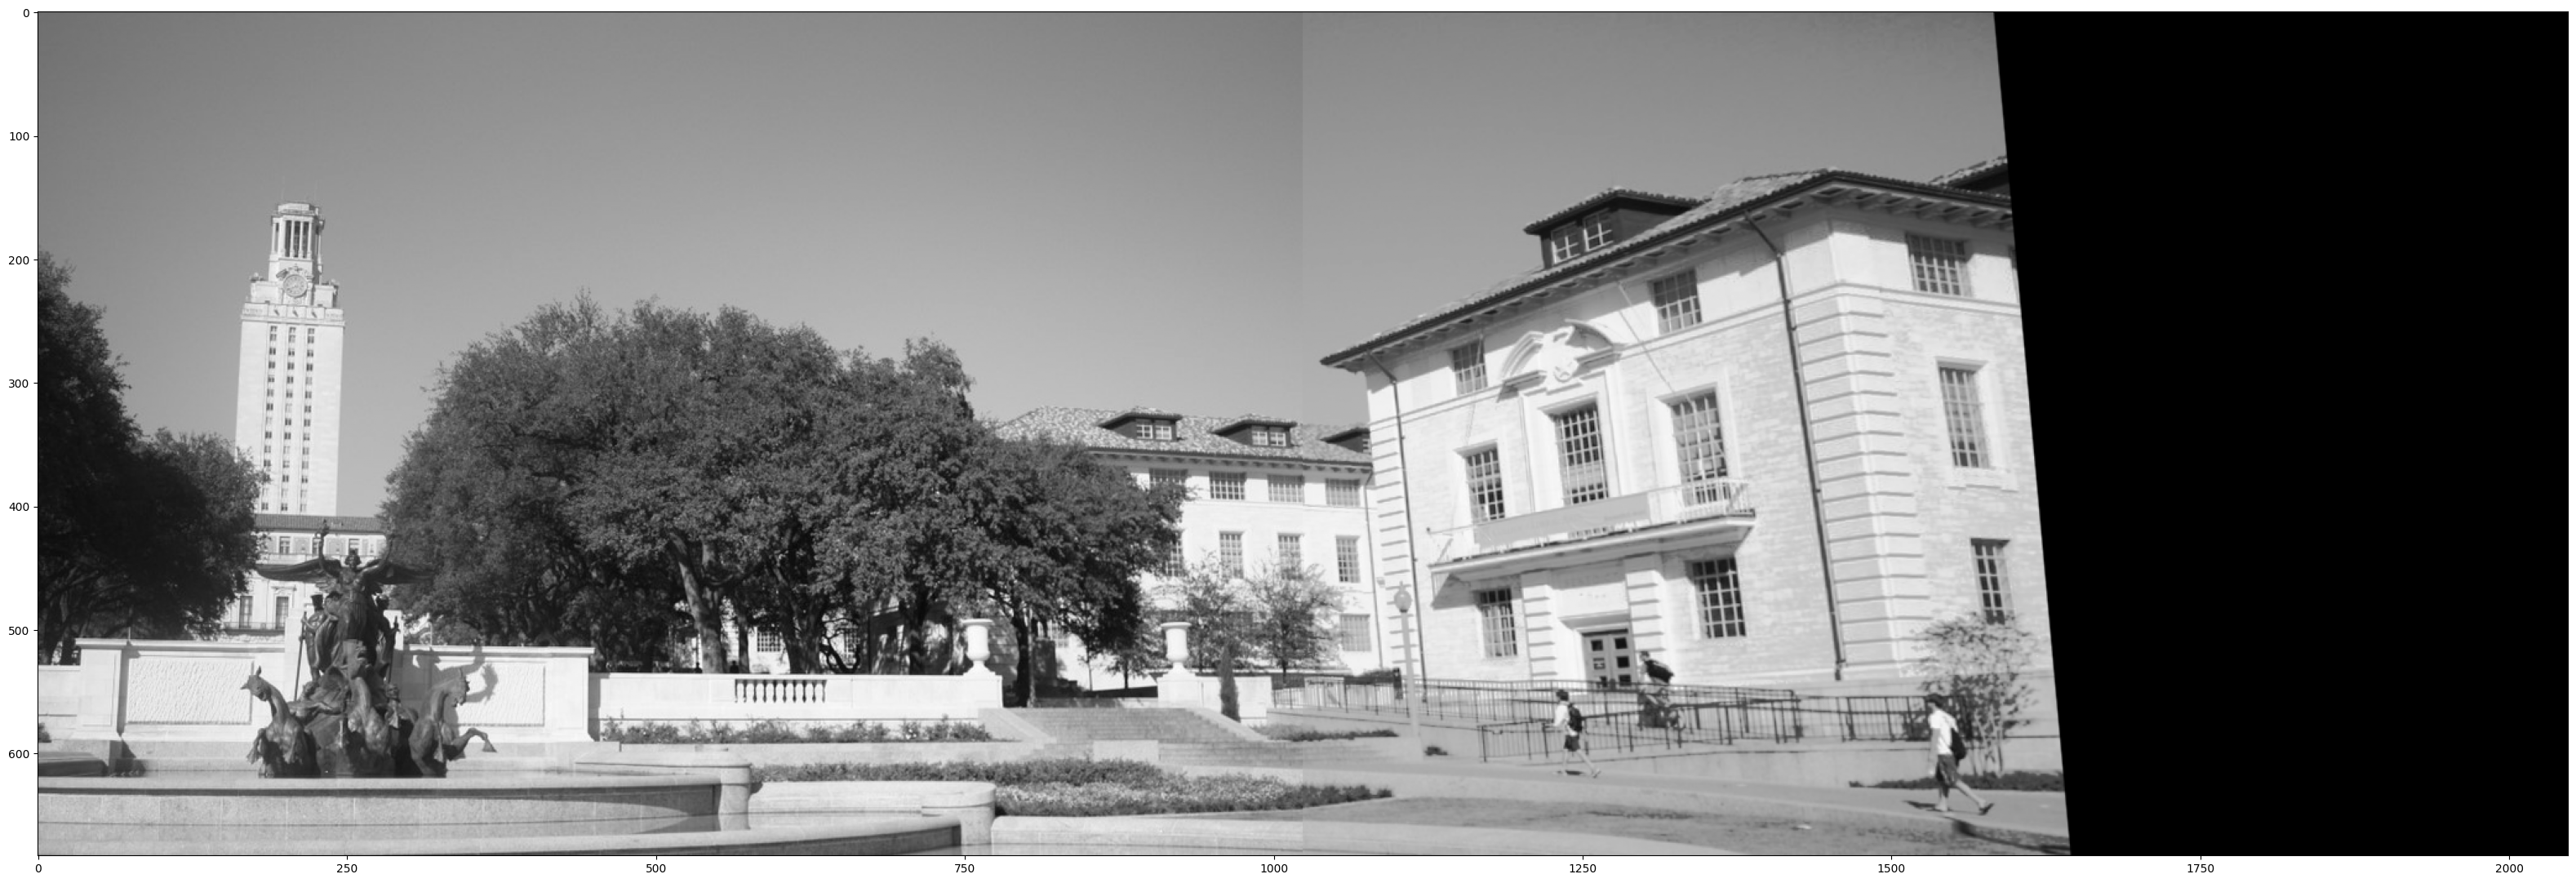

In [21]:
img2_histmatch = exposure.match_histograms(img2, img1)

result = cv2.warpPerspective(img2_histmatch, np.linalg.inv(H / H[2, 2]), (img1.shape[1] + img2.shape[1], img1.shape[0]))
result[0:img1.shape[0], 0:img1.shape[1]] = img1

plt.figure(figsize=(40,20)),plt.imshow(result,cmap='gray')
plt.show()